# K-Means Clustering

## 1. Importing / Installing packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns

from sklearn.cluster import KMeans, k_means
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## 2. Loading the Raw Data into Python

In [2]:
df_raw = pd.read_csv("wellHeader_with_Cluster.csv",
                     dtype={'ChosenID':str},parse_dates=['FirstProdDate','Comp_Dt'])

df_raw.shape

(2514, 20)

In [3]:
# Renaming cluster column to bundle
df_raw = df_raw.rename(columns={'cluster':'bundle'})

## 3. Data Preprocessing

### 3.1. Exploratory Data Analysis & Data Cleaning


In [5]:
# Checking for null values
df_raw.isnull().sum()

ChosenID               0
Basin                  0
WellName               0
County                 0
LeaseName              0
bundle                 0
LeaseNumber          225
Field                  0
RES_CAT                0
Landing_Zone          17
PerfLateralLength      8
FirstProdDate          0
Comp_Dt              209
HoleDirection          0
SurfaceLatitude        0
SurfaceLongitude       0
BH_Lat                 7
BH_Long                7
mid_lat                0
mid_long               0
dtype: int64

In [7]:
# Investigate all the elements within each feature
for column in df_raw:
    unique_vals = df_raw[column].unique()
    nr_values = len(unique_vals)
    if nr_values <= 10:
        print(f"The number of values for feature {column} :{nr_values:,} -- {unique_vals}")
    else:
        print(f"The number of values for feature {column} :{nr_values:,}")

The number of values for feature ChosenID :2,514
The number of values for feature Basin :1 -- ['DB']
The number of values for feature WellName :2,514
The number of values for feature County :1 -- ['REEVES']
The number of values for feature LeaseName :1,440
The number of values for feature bundle :1,525
The number of values for feature LeaseNumber :1,378
The number of values for feature Field :16
The number of values for feature RES_CAT :4 -- ['01PDP' '02PDNP' '02PA' '03PUD']
The number of values for feature Landing_Zone :15
The number of values for feature PerfLateralLength :2,011
The number of values for feature FirstProdDate :208
The number of values for feature Comp_Dt :1,405
The number of values for feature HoleDirection :3 -- ['H' 'V' 'D']
The number of values for feature SurfaceLatitude :2,377
The number of values for feature SurfaceLongitude :2,470
The number of values for feature BH_Lat :2,504
The number of values for feature BH_Long :2,505
The number of values for feature mid_

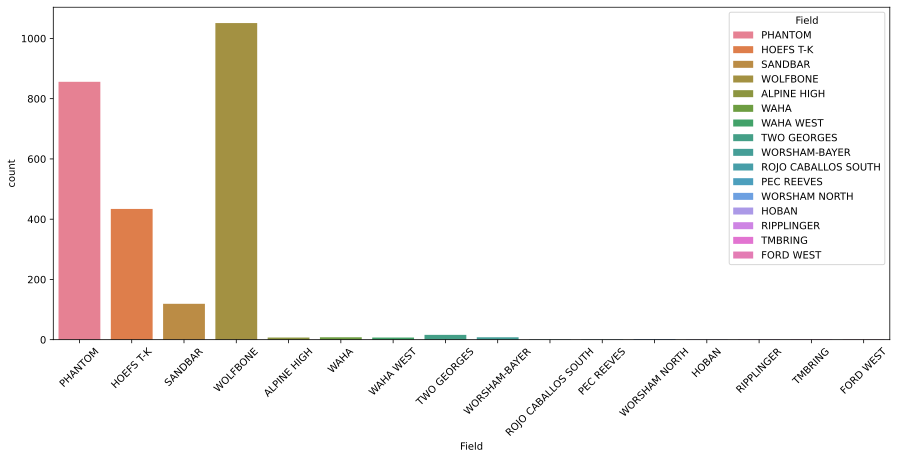

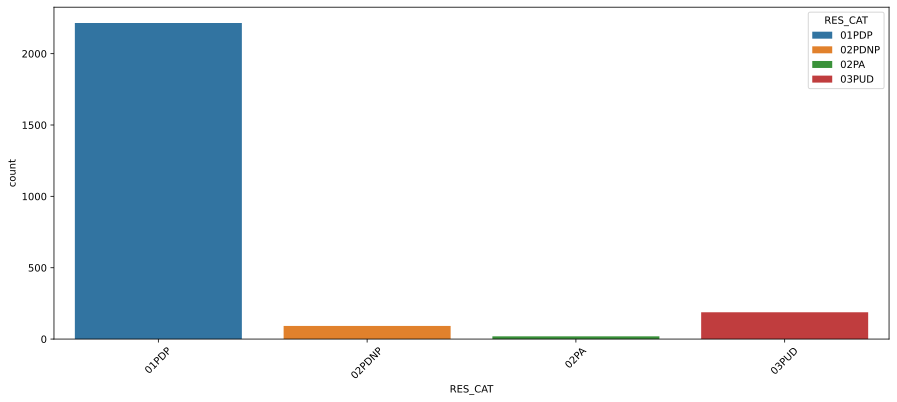

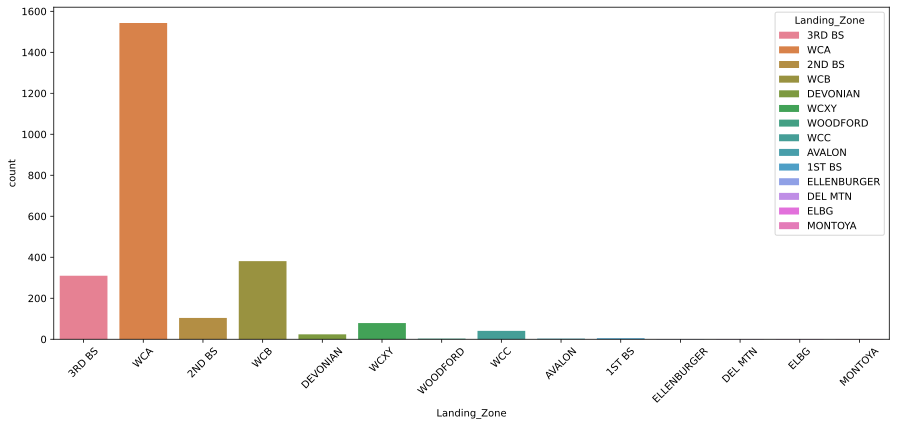

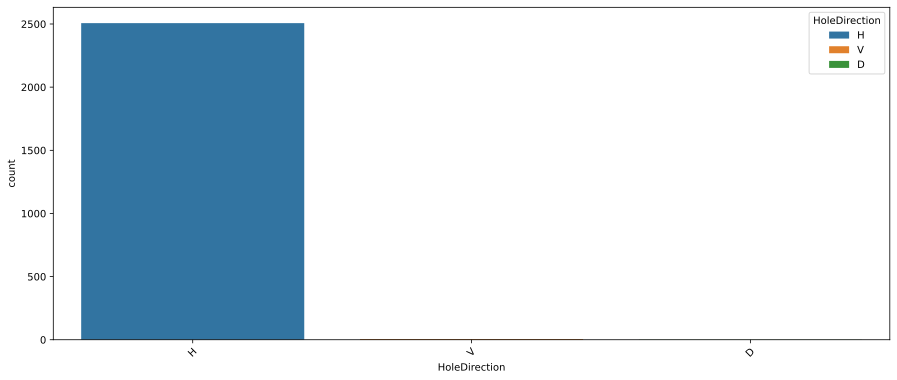

In [8]:
# Looping through all the features by our y variable - see if there is relationship
# object_cols = [col for col in df_raw.columns if df_raw[col].dtypes.name == 'object']

for f in ['Field','RES_CAT','Landing_Zone','HoleDirection']:
    # Set the figure size
    plt.figure(figsize=(15, 6))
    
    sns.countplot(x = f, data = df_raw, hue=f,legend=True)
    plt.xticks(rotation=45)

### 3.2. Feature Engineering


In [9]:
df_raw['First_Prod_Year'] = pd.DatetimeIndex(df_raw['FirstProdDate']).year
df_raw['First_Prod_Month'] = pd.DatetimeIndex(df_raw['FirstProdDate']).month

In [10]:
# Dropping First ProdDate & API10/ChosenID
df_FeatureEng_clustering = df_raw[[
    'bundle','First_Prod_Year','First_Prod_Month'
]].reset_index(drop=True).copy()

In [11]:
# Create a MinMaxScaler for normalization
min_max_scaler = MinMaxScaler()

# Normalize the data
df_normalized_clustering = pd.DataFrame(min_max_scaler.fit_transform(df_FeatureEng_clustering), columns=df_FeatureEng_clustering.columns)

## 4. Running PCA

### 4.1. Identifying the "best" number of components


Total Variance in our dataset is: 0.20275363039943833
The 95% variance we want to have is: 0.1926159488794664
Variance explain with 1 n_compononets: 0.101341909663374
Variance explain with 2 n_compononets: 0.19691085758569254
Variance explain with 3 n_compononets: 0.20275363039943833


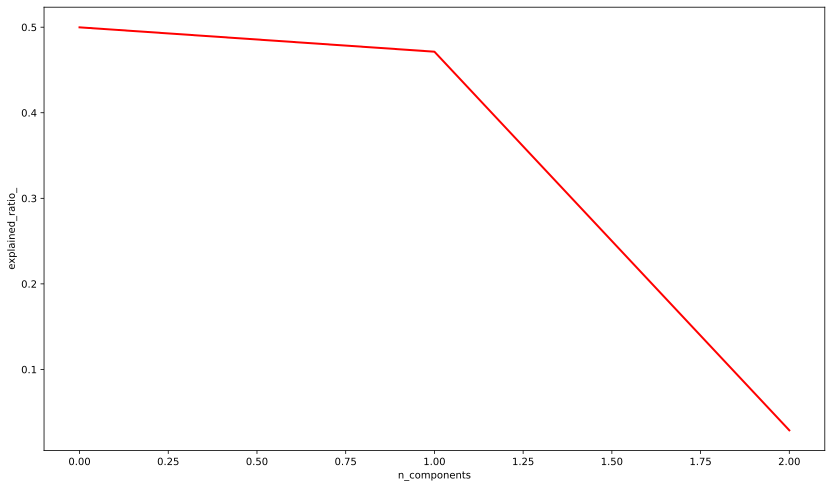

In [12]:
X = df_normalized_clustering.values
n_components = X.shape[1]

# Running PCA with all components
pca = PCA(n_components=n_components, random_state=453)
X_r = pca.fit(X).transform(X)

# Calculating the 95% Variance
total_variance = sum(pca.explained_variance_)
var_95 = total_variance * 0.95

print(f"Total Variance in our dataset is: {total_variance}")
print(f"The 95% variance we want to have is: {var_95}")

# Creating a df with the components and explained variance
a = zip(range(0,n_components), pca.explained_variance_)
a = pd.DataFrame(a, columns=["PCA Comp", "Explained Variance"])

# Trying to hit 95%
for i in np.arange(len(a)):
    print(f"Variance explain with {i+1} n_compononets: {sum(a['Explained Variance'][0:i+1])}")

# Plotting the Data
plt.figure(1, figsize=(14, 8))
plt.plot(pca.explained_variance_ratio_, linewidth=2, c="r")
plt.xlabel('n_components')
plt.ylabel('explained_ratio_')
plt.show()

## 5. Running K-Means

### 5.1. Identifying the optimal number of clusters to use in k-means using "elbow-method"

In [13]:
def calculate_elbow_method(data: np.ndarray) -> None:
    """
    This function calculates and plots the Elbow Method for the optimal value of k in KMeans clustering.

    Parameters:
    data (np.ndarray): The dataset for which to calculate the optimal number of clusters.

    Returns:
    None: This function does not return a value. It displays a plot.
    """
    K = range(1,20) #[1,2,3,4,5,6,7,8,9]
    inertia = []

    #running Kmeans

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=2)
        kmeans = kmeans.fit(data)
        u = kmeans.inertia_
        inertia.append(u)
        print(f"The innertia for :{k} Clusters is:{u}")

    # Creating the scree plot for Intertia - elbow method
    fig, (ax1) = plt.subplots(1, figsize=(16,6))
    xx = np.arange(len(K))
    ax1.plot(xx, inertia)
    ax1.set_xticks(xx)
    ax1.set_xticklabels(K, rotation='vertical')
    plt.xlabel('n_components Value')
    plt.ylabel('Inertia Score')
    plt.title("Inertia Plot per k")

The innertia for :1 Clusters is:494.8369851128457
The innertia for :2 Clusters is:299.6632871231619
The innertia for :3 Clusters is:185.9102100014617
The innertia for :4 Clusters is:113.08441964460455
The innertia for :5 Clusters is:95.50002301682858
The innertia for :6 Clusters is:80.91746041097645
The innertia for :7 Clusters is:66.76988323787921
The innertia for :8 Clusters is:58.989271460494805
The innertia for :9 Clusters is:55.766073831396696
The innertia for :10 Clusters is:45.068538343322786
The innertia for :11 Clusters is:43.351296205446715
The innertia for :12 Clusters is:36.82016381214051
The innertia for :13 Clusters is:33.23081212508362
The innertia for :14 Clusters is:30.352632959821413
The innertia for :15 Clusters is:28.67667317337705
The innertia for :16 Clusters is:26.340355792240263
The innertia for :17 Clusters is:25.629430564815056
The innertia for :18 Clusters is:24.52635473375346
The innertia for :19 Clusters is:23.6852577994532


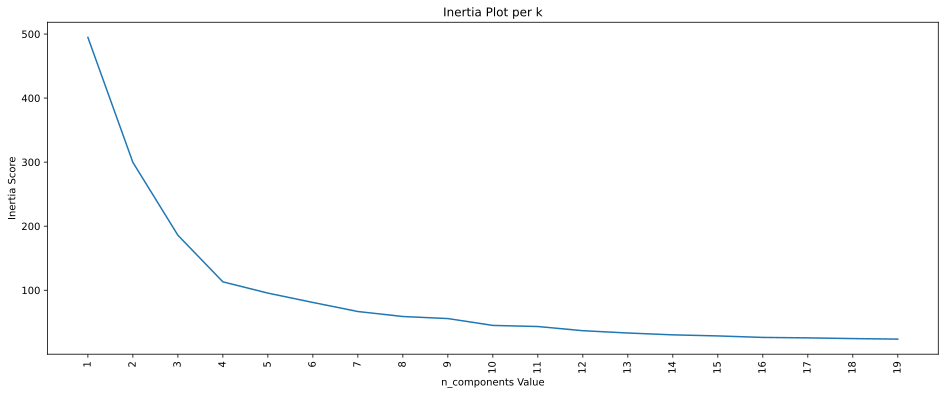

In [14]:
# Running PCA again with correct no. of principal components

pca = PCA(n_components=2, random_state = 453)
X_r = pca.fit(X).transform(X)

calculate_elbow_method(data=X_r)

### 5.2. Running K-means

In [15]:
kmeans = KMeans(n_clusters=4, random_state=1).fit(df_normalized_clustering.values)
kmeans.labels_

array([2, 2, 2, ..., 3, 0, 0])

### 5.3. Merging K-means clusters back to the df_raw_filter_ResvCat

In [17]:
df_raw['Parent_Child_Cluster_Labels'] = kmeans.labels_

In [20]:
df_raw.columns

Index(['ChosenID', 'Basin', 'WellName', 'County', 'LeaseName', 'bundle',
       'LeaseNumber', 'Field', 'RES_CAT', 'Landing_Zone', 'PerfLateralLength',
       'FirstProdDate', 'Comp_Dt', 'HoleDirection', 'SurfaceLatitude',
       'SurfaceLongitude', 'BH_Lat', 'BH_Long', 'mid_lat', 'mid_long',
       'First_Prod_Year', 'First_Prod_Month', 'Parent_Child_Cluster_Labels'],
      dtype='object')

In [24]:
df_raw.to_csv("WellHeader_with_Bundle_PC_Clusters.csv",index=False,mode='w')